# Variational Autoencoder (VAE) with Heterogeneous Attribute Likelihood Model (H-VAE)


VAEs are typically discussed in the literature in the context of image data which is homogeneously typed. Hence, most VAE likelihoods use the multivariate normal distribution which assumes that the data being modeled are real-valued and continuous. Tabular data are often heterogeneously typed, consisting of mixed real, categorical, count, etc. data. The underyling datasets used in statistical decision making systems in applications such as law and finance are often tabular. Recent work has demonstrated the use of neural-generative models such as VAEs in modeling the data manifolds used in these systems and producing explanations or recourse (amelioratory actions to receive a better decision) for individual predictions. Therefore, it is of practical interest to the recourse problem to be able to explicitly model heterogeneous attribute tabular data with these neural-generative models. 

This notebook presents a modification of the VAE likelihood detailed in the Heterogeneous-Incomplete VAE paper (https://arxiv.org/abs/1807.03653) which explicitly accounts for these different data types. Two examples are presented. 

As the PyTorch distributions package abstracts away the details of the underlying log likelihoods for the different distributions considered, we do not discuss the explicit likelihood and KL divergence calculations.


## Table of Contents:
1. [Statistical Data Types](#statistical-data-types)
2. [VAE Derivation](#vae-derivation)
3. [Inspection and Debugging Functions](#inspection-debugging)
4. [H-VAE Implementation](#hvae-implementation)
5. [Simple mixed real-categorical example](#example1)
6. [Complicated mixed real-categorical example](#example2)

## Statistical Data Types <a class="anchor" id="statistical-data-types"></a>

The different types of tabular data include:

* Binary: A discrete outcome data type with exactly two possible outcomes. For example, yes/no, true/false, etc. There is no sense of ordering for these outcomes.

modeled with a Bernoulli distribution where the probability of success is a function (deep neural network) of the latent representation $\mathbf{z}$. That is, $x \sim Ber(p_{\theta} (\mathbf{z}))$

* Categorical: A discrete outcome data type with more than two possible outcomes. For example, red/green/blue. There is no sense of ordering for these outcomes.

modeled with a Categorical distribution where the probability vector is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network: $x \sim Cat(p_{\theta} (\mathbf{z}))$

* Ordinal: A discrete outcome data type where there is some sense of ordering among the outcomes. For example, bad/neutral/good or freezing/cold/comfortable/warm/hot. 

This data type is modeled with an ordinal logit model, which is a type of censored data process. 

For an ordinal logit model with K categories, it is assumed that there is an unobserved continuous variable $y^*$ and the positive real line is partitioned by K-1 thresholds. The regions between the thresholds are the K categories. Wherever $y^*$ lands is the ordinal category that is observed. 

We assume that the probability that the ordinal category R is less than or equal to r is 

\begin{equation}
Pr(R \le r) = \sigma(g_{\theta}^r(\mathbf{z}) - h_{\theta}(\mathbf{z}))
\end{equation}

where $\sigma$ is the standard logistic function, $g^{r}_{\theta}$ is a deep neural network determining the $rth$ threshold, and $ h_{\theta}$ is a function determining where the censored variable lands. Then the probabilities for each ordinal category are determined via:

\begin{equation}
p(R=r) = Pr(R \le r) - Pr(R \le r-1)
\end{equation}

and are used as the parameters for a categorical distribution. The output of the "decoder" has K values: K-1 thresholds values and the "latent" random variable. A softplus activation function is applied to the threshold values and then are cumulatively summed in order to enforce positivity and monotonicity. 

\begin{equation}
D_{\theta}(\mathbf{z}) = [h_{\theta}(\mathbf{z}), \text{softplus}(g^1_{\theta}(\mathbf{z}) ), \text{softplus}(g^1_{\theta}(\mathbf{z}) ) + \text{softplus}(g^2_{\theta}(\mathbf{z}) ), ..., \text{softplus}(g^1_{\theta}(\mathbf{z}) ) + ... + \text{softplus}(g^{K-1}_{\theta}(\mathbf{z}) ) ]
\end{equation}

* Bounded Count: A nonnegative integer valued data type that has an upper bound. I.e, takes on the values 0, 1, 2, ..., N.

modeled with a Binomial distribution where the probability of success is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim Bin(p_{\theta} (\mathbf{z}), N)$ where N is assumed to be known.

* Unbounded Count: A nonnegative integer that has no upper bound. I.e, takes on the values 0, 1, 2, ...

modeled with a Poisson distribution where the rate is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim Pois(\lambda_{\theta} (\mathbf{z}))$.

* Positive Real: A positive real number. I.e. takes on a value in the interval $(0, \infty)$

modeled with a lognormal distribution where the mean is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim lognormal(\mu_{\theta} (\mathbf{z}), \sigma^2)$ where $\sigma^2$ is assumed to be known.

* Real: A real number. I.e. takes on a value in the interval $(-\infty, \infty)$.

modeled with a normal distribution where the mean is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim normal(\mu_{\theta} (\mathbf{z}), \sigma^2)$ where $\sigma^2$ is assumed to be known.



### Normalization Strategies

* Real: Standardize
* Lognormal: Standardize in log space. Can also just take log and treal as real-valued. 
Note: PyTorch computes the log_prob of the lognormal distribution by taking the log of the input and computing the normal log prob times a Jacobian determinant scaling factor
* Count / Binomial: When count is small, do not normalize. When count is large, approximate as real. 


### Other Notes

All components of the H-VAE likelihood are conditionally independent given $\mathbf{z}$.

## VAE Derivation <a class="anchor" id="vae-derivation"></a>

### Definitions

#### Entropy

Entropy is a property of a probability distribution. One interpretation is that it's a measure of how "random" the distribution is e.g. a uniform distribution is more random than a distribution with most of its mass concentrated around a single number. Entropy for continuous distributions is often known as "differential entropy".

$$
H(p) = - \mathbb{E}_{p} \left[\log p \right] = -\int p(x)\log(p(x))dx
$$

#### KL Divergence

The KL divergence is a discrepancy measure between two probability distributions and is used as an optimization objective in variational inference to find the variational parameters that make the variational distribution as close as possible to the target distribution. The KL divergence is not a true metric and does not follow the triangle inequality and is not symmetric. Crucially, the behavior of the KL divergence as the variational optimization objective changes depending on the ordering of the distributions.

Let p(x) be the true distribution that we wish to approximate and q(x) be our variational distribution. 

<img src="fig/KL.png" style="height:200px;" align="center">

The forward KL divergence (mean-seeking, attempts to cover as much of p as possible, better approximates variance, less computationally tractable) is:
\begin{align*}
D_{KL} (p(X) || q(X)) = \mathbb{E}_{p(x)} \left[-\log \frac{q(x)}{p(x)} \right] \
\end{align*}

The reverse KL divergence (mode-seeking, attempts to cover a single mode of p, under approximates variance, more computationally tractable and therefore the more common objective) is:
\begin{align*}
D_{KL} (q(X) || p(X)) = \mathbb{E}_{q(x)} \left[-\log \frac{p(x)}{q(x)} \right]  \
\end{align*}


### Generative Process

A ***variational autoencoder*** is both a latent variable model and an inference method. For a VAE model, we assume that the data is generated by the following process:
<table>
    <tr>
        <td>
            <img src="fig/vae_graphical.png" style="height:200px;" align="center">
        </td>
        <td>
            \begin{align}
            z_n &\sim p_\theta(z), \; \mathbf{(prior)}\\
            x_n &\sim p_\theta(x_n|z_n), \; \mathbf{(likelihood)}
            \end{align}
        </td>
    </tr>
</table>
where the likelihood $p_\theta(x_n|z_n)$ is some distribution parameterized by $f_\theta(z_n)$. The goal of a VAE model is to:

$\mathbf{1.}$ learn the function $f_\theta$, ***the generative network***, to mimic the empirical distribution of observed data <br><br>
$\mathbf{2.}$ learn a function $g_\phi$, ***the inference network***, to infer the best Gaussian approximation $\mathcal{N}(\mu(y_n), \Sigma(y_n))$ to the posterior $p(z_n|y_n)$ given an observation $y_n$

### Derivation of ELBO + Interpretation as an EM algorithm

Assuming generative model above, $z \sim p_{\theta}(z), x_n \sim p_{\theta}(x_n|z_n)$ we wish to maximize the observed log likelihood: 

\begin{align*}
\theta_{MLE} &= \underset{\theta}{argmax} \log \prod_{i=1}^n p_{\theta}(x_n)  \\
&= \underset{\theta}{argmax}  \sum_{i=1}^n \log \int p_{\theta}(x_n|z_n) p_{\theta}(z_n)dz_n \\
&= \underset{\theta}{argmax}  \sum_{i=1}^n \log \mathbb{E}_{p_{\theta}(z_n)} \left[ p_{\theta}(x_n | z_n) \right] \\
\end{align*}

The above is an intractable optimization objective so we introduce a surrogate distribution and use jensen's inequality:

\begin{align*}
\theta_{MLE} &= \underset{\theta}{argmax} \log \prod_{i=1}^n p_{\theta}(x_n)  \\
&= \underset{\theta}{argmax}  \sum_{i=1}^n \log \int \frac{p_{\theta}(x_n|z_n) p_{\theta}(z_n)q(z_n)}{q(z_n)}dz_n \\
&= \underset{\theta}{argmax}  \sum_{i=1}^n \log \mathbb{E}_{q(z_n)} \left[ \frac{p_{\theta}(x_n , z_n)}{q(z_n)} \right] \\
&\ge \underset{\theta}{argmax}  \sum_{i=1}^n \mathbb{E}_{q(z_n)} \left[\log  \frac{p_{\theta}(x_n , z_n)}{q(z_n)} \right] \\
\end{align*}

The ELBO is then:

\begin{align*}
ELBO(\theta, q) &= \sum_{i=1}^n \mathbb{E}_{q(z_n)} \left[\log  \frac{p_{\theta}(x_n , z_n)}{q(z_n)} \right]
\end{align*}

One could naively optimize this via coordinate ascent / EM, but for the E step, $p(z_n| x_n)$ is intractable if $p(x_n | z_n)$ uses a neural network. Instead, use a variational approximation and say that

\begin{align*}
q(z_n) = \mathcal{N}(\mu_{\phi}(x_n), \Sigma_{\phi}(x_n))
\end{align*}

i.e. there's some function parameterized by $\phi$ which maps $x_n$ to both the mean and (diagonal) covariance matrix which parameterize q.

The ELBO becomes:
\begin{align*}
ELBO(\theta, \phi) &= \sum_{i=1}^n \mathbb{E}_{q_{\phi}(z_n)} \left[\log  \frac{p_{\theta}(x_n , z_n)}{q_{\phi}(z_n)} \right]
\end{align*}

and $\phi$ and $\theta$ can be jointly trained.

One then uses the reparameterization truck + SGD to train a VAE. 

Let $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and $z_n \sim \Sigma_{\phi}^{\frac{1}{2}}(x_n) \epsilon + \mu_{\phi}(x_n)$


\begin{align*}
ELBO(\theta, \phi) &= \sum_{i=1}^n \mathbb{E}_{q_{\phi}(z_n)} \left[\log  \frac{p_{\theta}(x_n , z_n)}{q_{\phi}(z_n)} \right] \\
&= \sum_{i=1}^n \mathbb{E}_{\epsilon} \left[\log  \frac{p_{\theta}(x_n , \Sigma_{\phi}^{\frac{1}{2}}(x_n) \epsilon + \mu_{\phi}(x_n))}{q_{\phi}(\Sigma_{\phi}^{\frac{1}{2}}(x_n) \epsilon + \mu_{\phi}(x_n))} \right] \\
\end{align*}

In practice, the expectations use only one sample.

### Forms of ELBO

The ELBO can be rewritten to take on several different but equivalent forms that offer insight into what the VAE optimization objective is achieving.

#### Vanilla ELBO
$$
\theta^*, \phi^* = \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n, z_n)}{q_{\phi}(z_n)} \right]
$$


#### Joint + Entropy

The VAE learning algorithm can be viewed as maximizing the expected likelihood of joint distribution and the entropy of the posterior approximation.

\begin{align*}
\theta^*, \phi^* &= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n, z_n)}{q_{\phi}(z_n)} \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n, z_n) \right] - \mathbb{E}_{z\sim q_{\phi}(z_n)} \left[\log q_{\phi}(z_n) \right] \right] \\ 
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n, z_n) \right] + H(q_{\phi}(z_n)) \right]\\ 
\end{align*}



#### Expected Log Likelihood minus KL

It can also be viewed as maximizing the expected log likelihood and minimizing the KL divergence between the posterior and the prior. This is the optimization objective used in our implementation.

\begin{align*}
\theta^*, \phi^* &= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n, z_n)}{q_{\phi}(z_n)} \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n| z_n)p_{\theta}(z_n)}{q_{\phi}(z_n)} \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n| z_n)\right] - \mathbb{E}_{z\sim q_{\phi}} \left[ \log \frac{q_{\phi}(z_n)}{p_{\theta}(z_n)}\right] \right]  \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n| z_n)\right] - D_{KL}(q_{\phi}(z_n) || p_{\theta}(z_n) ) \right] 
\end{align*}

The first time is often viewed as a "reconstruction error" and the second term is often viewed as a "regularization" term. The first term causes the VAE to approximate the data well and the second term causes the VAE to learn a richer latent representation. 

The second term has a closed form when the prior and posterior over $\mathbf{z}$ are normal, which describe below.


#### Observed Log Likelihood minus KL

Finally, the VAE can be viewed as maximizing the data log likelihood and minimizng a KL divergence between the approximate and true posterior. 

\begin{align*}
\theta^*, \phi^* &= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n, z_n)}{q_{\phi}(z_n)} \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(x_n, z_n)p_{\theta}(x_n)}{q_{\phi}(z_n)p_{\theta}(x_n)} \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log\frac{p_\theta(z_n | x_n)p_{\theta}(x_n)}{q_{\phi}(z_n)} \right] \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[p_{\theta}(x_n)\right] - \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\frac{q_{\phi}(z_n)}{p_\theta(z_n | x_n)}\right] \right] \\
&= \mathrm{argmax}_{\theta, \phi} \sum_{n=1}^N \left[ p_{\theta}(x_n) - D_{KL}(q_{\phi}(z_n) || p_\theta(z_n | x_n)) \right] \\
\end{align*}



## Explicit objective derivation for Expected Log Likelihood minus KL:

* $P_{\theta}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \mathbf{0}, \mathbf{I})$
* $P_{\theta}(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mathbf{x}; \mu_{\theta}(\mathbf{z}), \Sigma_{\theta}(\mathbf{z}))$

\begin{align*}
-ELBO(\theta, \phi) &= \sum_{n=1}^N  \left[- \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n| z_n)\right] + D_{KL}(q_{\phi}(z_n) || p_{\theta}(z_n) )  \right] \\
&= - \sum_{n=1}^N  \mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n| z_n)\right] + \sum_{n=1}^N D_{KL}(q_{\phi}(z_n) || p_{\theta}(z_n) )  \\
&\approx - \sum_{n=1}^N \frac{1}{L} \sum_{i=1}^L  \log p_\theta(x_n| z_n^{(l)}) + \sum_{n=1}^N D_{KL}(q_{\phi}(z_n) || p_{\theta}(z_n) )  \\
&\approx - \frac{N}{M} \sum_{m=1}^M \frac{1}{L} \sum_{i=1}^L  \log p_\theta(x_m| z_m^{(l)}) + \frac{N}{M} \sum_{m=1}^M D_{KL}(q_{\phi}(z_m) || p_{\theta}(z_m) )  \\
\end{align*}

We use monte carlo approximations to estimate $\mathbb{E}_{z\sim q_{\phi}(z_n)}\left[\log p_\theta(x_n| z_n)\right]$ because the computation is analytically intractable, but assuming $p_{\theta}(\mathbf{z})$ and $q_{\phi}(\mathbf{z})$ are both multivariate normals, we can derive an analytic expression for $D_{KL}(q_{\phi}(z_m) || p_{\theta}(z_m) )$. Ref. kingma (2013) appendix B:

Let J be the dimensionality of $\mathbf{z}$

\begin{align*}
-D_{KL}(q_{\theta}(\mathbf{z}) || p_{\theta}(\mathbf{z})) &= \int q_{\mathbf{\theta}} (\mathbf{z}) (\log p_{\theta}(\mathbf{z}) - \log q_{\theta}(\mathbf{z}))d \mathbf{z} \\
&= \int q_{\mathbf{\theta}} (\mathbf{z}) \log p_{\theta}d \mathbf{z} - \int q_{\mathbf{\theta}} (\mathbf{z})\log q_{\theta}(\mathbf{z}))d \mathbf{z} \\
&= \left[ - \frac{J}{2} \log(2 \pi) - \frac{1}{2} \sum_{j=1}^{J} \left(\mu_j^2 + \sigma_j^2 \right) \right] - \left[ -\frac{J}{2} \log(2 \pi) - \frac{1}{2} \sum_{j=1}^J (1 + \log \sigma_j^2) \right]  \\
&= \frac{1}{2} \sum_{j=1}^J \left(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)
\end{align*}

where in line 2 the term on the left is the cross entropy and the term on the right is the entropy

so

\begin{align*}
D_{KL}(q_{\theta}(\mathbf{z}) || p_{\theta}(\mathbf{z})) &= - \frac{1}{2} \sum_{j=1}^J \left(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)
\end{align*}

and the last line of the objective becomes

\begin{align*}
&\approx - \frac{N}{M} \sum_{m=1}^M \frac{1}{L} \sum_{l=1}^L  \log p_\theta(x_m| z_m^{(l)}) + \frac{N}{M} \sum_{m=1}^M - \frac{1}{2} \sum_{j=1}^J \left(1 + \log \sigma_{j, m}^2 - \mu_{j, m}^2 - \sigma_{j, m}^2 \right)  \\
\end{align*}

L=1 is used in practice.

Assuming $p_\theta(x_m| z_m) \sim \mathcal{N} (\mu_{\theta}(z_m), \Sigma_{\theta} (z_m))$.

Let K be the dimensionality of x. Assuming a multivariate normal likelihood:



\begin{align*}
\log p_\theta(x_m| z_m) &= -\frac{K}{2} \log (2\pi) - \frac{1}{2} \sum_{k=1}^K \log \Sigma_{\theta}^{k,k} (z_m) - \frac{1}{2} \sum_{k=1}^K \frac{(x_m^k - \mu_{\theta}^k(z_m))^2}{\Sigma_{\theta}^{k,k} (z_m)} \\
\end{align*}

This notebook assumes a composite likelihood which is a product of possibly multiple different distributions representing the different statistical data types.


### Learning Algorithm
1. Get batch of M xs
2. For each $x_n$, sample L $z_n$s
3. Compute objective as above, using pytorch for the gradient computations
4. Take optimizer step
5. Repeat until convergence

We use the PyTorch distributions library to abstract away the explicit forms of the likelihoods and KL divergences.



### References

#### PyTorch
* https://pytorch.org/docs/stable/index.html
* https://github.com/pytorch/examples/blob/master/vae/main.py
* https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py
* https://graviraja.github.io/vanillavae/#
* https://pyro.ai/examples/vae.html
* https://medium.com/@sikdar_sandip/implementing-a-variational-autoencoder-vae-in-pytorch-4029a819ccb6

#### VAE
* https://arxiv.org/pdf/1312.6114.pdf

#### KL Divergence
* https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/
* https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/

## Inspection and Debugging Functions <a class="anchor" id="inspection-debugging"></a>



In [2]:
from math import comb 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

m = D.LogNormal(torch.tensor([0.0]), torch.tensor([1.0]))

m.log_prob(torch.tensor([2.]))

# GLOBAL
SEED = 42
VERBOSITY = 0

# VAE
NUM_EPOCHS_TUNE = 200 
NUM_EPOCHS = 500
HIDDEN_DIM = 64
Z_PRIOR_VAR = 0.5**2
X_POST_VAR = 0.1**2


In [3]:
def plot_history_vae(vae):
    history = vae.history
    num_epochs = vae.num_epochs
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 20))
    
    ax[0].plot(range(1, num_epochs + 1),  history['avg_loss'], label='train epoch avg loss')
    ax[0].plot(range(1, num_epochs + 1),  history['val_avg_loss'], label='val avg loss')
    ax[0].set_title("Epoch average loss")
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Average loss')
    ax[0].legend()
    
    ax[1].plot(range(1, num_epochs + 1),  history['recon_error'], label='avg recon error')
    ax[1].plot(range(1, num_epochs + 1),  history['val_recon_error'], label='avg val recon error')
    ax[1].set_title("Epoch average recon error")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Average reconstruction error')
    ax[1].legend()
    
    ax[2].plot(range(1, num_epochs + 1),  history['kl_penalty'], label='avg kl penalty')
    ax[2].plot(range(1, num_epochs + 1),  history['val_kl_penalty'], label='avg kl penalty')
    ax[2].set_title("Epoch average kl penalty")
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Average kl penalty')
    ax[2].legend()

    plt.show()
    plt.close()


In [4]:
def debug_nd_vae(vae, hist_kwargs={'density': True, 'bins':100, 'alpha': 0.9}, use_val=False):
    if use_val:
        X = vae.val_X
        X_numpy = vae.val_X_numpy
        
        y = vae.val_y
        y_numpy = vae.val_y_numpy
    else:
        X = vae.train_X
        X_numpy = vae.train_X_numpy
        
        y = vae.train_y
        y_numpy = vae.train_y_numpy
        
        
    with torch.no_grad():
        mu_z, logvar_z, sample_z, qz_x = vae.encode(X)
        mu_x, sample_x, _ = vae.decode(sample_z)

        sample_z_synthetic = vae.p_z.sample((len(y),))
        mu_x_synthetic, sample_x_synthetic, _ = vae.decode(sample_z_synthetic)
        


        
    fig, ax = plt.subplots(vae.z_dim, 1, figsize=(15, vae.z_dim*5))
    for i in range(vae.z_dim):
        if vae.z_dim == 1:
            ax.hist(sample_z.detach().numpy()[:, i],  **hist_kwargs)

            ax.set_title(f'Hist for marginal {i+1} of z')
        
        else:
            ax[i].hist(sample_z.detach().numpy()[:, i], **hist_kwargs)

            ax[i].set_title(f'Hist for marginal {i+1} of z')
        
    plt.show()
    plt.close()
    
    

    # histograms of attributes 
    fig, ax = plt.subplots(vae.x_dim, 3, figsize=(15, 4 * vae.x_dim))
    
    for i in range(vae.x_dim):
        ax[i][0].hist(X_numpy[:, i].flatten(),  **hist_kwargs)
        ax[i][0].set_title(f'Feature {vae.featnames[i]} dist orig')
        
        
        ax[i][1].hist(sample_x.detach().numpy()[:, i].flatten(),  **hist_kwargs)
        ax[i][1].set_title(f'Feature {vae.featnames[i]} dist reconstructed')
        
        ax[i][2].hist(sample_x_synthetic.detach().numpy()[:, i].flatten(),  **hist_kwargs)
        ax[i][2].set_title(f'Feature {vae.featnames[i]} dist synthetic')
        
        
    plt.show()
    plt.close()
    
    # relationships
    df_orig = pd.DataFrame(X_numpy)
    df_recon = pd.DataFrame(sample_x.detach().numpy())
    df_syn = pd.DataFrame(sample_x_synthetic.detach().numpy())
    
    print("original correlations")
    print(df_orig.corr())

    print("reconstructed correlations")
    print(df_recon.corr())
   
    
    print("synthetic correlations")
    print(df_syn.corr())
    
    df_orig.loc[:, 'class'] = y_numpy
    df_recon.loc[:, 'class'] = y_numpy
    df_syn.loc[:, 'class'] = y_numpy
    
    
    total_scatter_plots = comb(vae.x_dim, 2)
    if total_scatter_plots == 1:
        fig, ax = plt.subplots(1, 3)
        ax[0].scatter(X_numpy[:, 0].flatten(), 
                                X_numpy[:, 1].flatten(), 
                                alpha=0.5)

        ax[0].set_title(f'Scatter of features {vae.featnames[0]} and \n {vae.featnames[1]} orig')


        ax[1].scatter(sample_x.detach().numpy()[:, 0].flatten(), 
                            sample_x.detach().numpy()[:, 1].flatten(), 
                            alpha=0.5)

        ax[1].set_title(f'Scatter of features {vae.featnames[0]} and \n {vae.featnames[1]} reconstructed')

        ax[2].scatter(sample_x_synthetic.detach().numpy()[:, 0].flatten(), 
                            sample_x_synthetic.detach().numpy()[:, 1].flatten(), 
                        alpha=0.5)

        ax[2].set_title(f'Scatter of features {vae.featnames[0]} and \n {vae.featnames[1]} synthetic')
    else:
        fig, ax = plt.subplots(total_scatter_plots, 3, figsize=(15, 6 * total_scatter_plots))
        c = 0
        for i in range(vae.x_dim-1):
            for j in range(i+1, vae.x_dim): 
                ax[c][0].scatter(X_numpy[:, i].flatten(), 
                                    X_numpy[:, j].flatten(), 
                                    alpha=0.5)

                ax[c][0].set_title(f'Scatter of features {vae.featnames[i]} and \n {vae.featnames[j]} orig')


                ax[c][1].scatter(sample_x.detach().numpy()[:, i].flatten(), 
                                    sample_x.detach().numpy()[:, j].flatten(), 
                                    alpha=0.5)

                ax[c][1].set_title(f'Scatter of features {vae.featnames[i]} and \n {vae.featnames[j]} reconstructed')

                ax[c][2].scatter(sample_x_synthetic.detach().numpy()[:, i].flatten(), 
                                    sample_x_synthetic.detach().numpy()[:, j].flatten(), 
                                alpha=0.5)

                ax[c][2].set_title(f'Scatter of features {vae.featnames[i]} and \n {vae.featnames[j]} synthetic')

                c += 1

            
            
    plt.show()
    plt.tight_layout()
    plt.close()

## H-VAE Implementation <a class="anchor" id="hvae-implementation"></a>

In [9]:
class HVAE(nn.Module):
    def __init__(self, x_dim, z_dim, L=1, hidden_dim=64, 
                 z_prior_var=1., 
                 likelihood_partition=None,
                 likelihood_params = {'x_post_var' : 1., 'x_post_var_lognormal': 0.25**2}, 
                 optimizer=None, verbosity=0, device='cpu'):
        super().__init__()
        
        if likelihood_partition is None:
            # range for feature types
            self.likelihood_partition = {
                (0, x_dim-1): 'real'
            }
        else:
            self.likelihood_partition = likelihood_partition
            
        self.likelihood_params = likelihood_params

        p_z_loc = torch.zeros(z_dim).to(device)
        cov_diag = z_prior_var*torch.ones(z_dim).to(device)
 
        self.device = device
        
        self.p_z = D.Normal(loc=p_z_loc,
                            scale=cov_diag.sqrt())
        
        self.z_prior_var = z_prior_var

        
        # samples in stochastic estimate of reconstruction error
        self.L = L
        
        self.x_dim = x_dim
        self.z_dim = z_dim
       
        self.verbosity = verbosity
        
        self.hidden_dim = hidden_dim

        self.encoder = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * z_dim) # mean and logvar
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim)
        )

    
        
        if optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), 
                             lr=0.001, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)
        else:
            self.optimizer = optimizer  
            
        self.train_dataset = None
        self.val_dataset = None
        
     
            
            
    def set_train_dataset(self, train_dataset, featnames=None):
        self.train_dataset = train_dataset
        self.train_X = train_dataset.data
        self.train_X_numpy = train_dataset.data.cpu().detach().numpy()
        
        self.train_y = train_dataset.targets
        self.train_y_numpy = train_dataset.targets.cpu().detach().numpy()
        
        if featnames is not None:
            self.featnames = featnames
        else:
            self.featnames = list(range(self.train_X_numpy.shape[1]))

    def set_val_dataset(self, val_dataset):
        self.val_dataset = val_dataset
        self.val_X = val_dataset.data
        self.val_X_numpy = val_dataset.data.cpu().detach().numpy()
        
        self.val_y = val_dataset.targets
        self.val_y_numpy = val_dataset.targets.cpu().detach().numpy()
    
    def encode(self, x):
        out = self.encoder(x)
        mu_z = out[:, :self.z_dim]
        logvar_z = out[:, self.z_dim:]  # decorrelated gaussian

        
        qz_x = torch.distributions.Normal(
                        loc=mu_z,
                        scale=(logvar_z/2).exp())


        sample_z = qz_x.rsample()
        return mu_z, logvar_z, sample_z, qz_x
                                       
    def decode(self, z):
        params = self.decoder(z)

        px_z = []
        samples = []
        
        for indices in self.likelihood_partition:
            data_type = self.likelihood_partition[indices]
            
            params_subset = params[:, indices[0]:indices[1] + 1]
            
            if data_type == 'real':
                cov_diag = self.likelihood_params['x_post_var']*torch.ones_like(params_subset).to(self.device)

                dist = torch.distributions.Normal(
                        loc=params_subset,
                        scale=cov_diag.sqrt())
                    
            elif data_type == 'categorical':
                dist = torch.distributions.OneHotCategorical(logits=params_subset)
            elif data_type == 'binary':
                dist = torch.distributions.Bernoulli(logits=params_subset)
            elif data_type == 'positive':
                lognormal_var = self.likelihood_params['x_post_var_lognormal']*torch.ones_like(params_subset).to(self.device)
                
                dist = torch.distributions.LogNormal(loc=params_subset, scale=lognormal_var.sqrt())
            elif data_type == 'count':
                positive_params_subset = F.softplus(params_subset)
                dist = torch.distributions.Poisson(rate=positive_params_subset)
            elif data_type == 'binomial':
                num_trials = self.likelihood_params['binomial_num_trials']
                dist = torch.distributions.Binomial(total_count=num_trials, logits=params_subset)
            elif data_type == 'ordinal':
                h = params_subset[:, 0:1]
                thetas = torch.cumsum(F.softplus(params_subset[:, 1:]), axis=1)
                                
                prob_lessthans = torch.sigmoid(thetas - h)
                probs = torch.cat((prob_lessthans, torch.ones(len(prob_lessthans), 1)), axis=1) - \
                        torch.cat((torch.zeros(len(prob_lessthans), 1), prob_lessthans), axis=1)
                                
                dist = torch.distributions.OneHotCategorical(probs=probs)
            else:
                raise NotImplementedError
                
                

            samples.append(dist.sample())
            px_z.append(dist)

        sample_x = torch.cat(samples, axis=1)
            
        return params, sample_x, px_z

    def forward(self, x):
        mu_z, logvar_z, sample_z, qz_x = self.encode(x)
        mu_x, sample_x, px_z = self.decode(sample_z)

        return mu_x, sample_x, px_z
    
    def recon_error(self, X, px_z):
        RL = None
        for indices, dist in zip(self.likelihood_partition, px_z):
            data_subset = X[:, indices[0]:indices[1] + 1]
            
            partial_RL = (-1. * dist.log_prob(data_subset))
            
            if len(partial_RL.shape) > 1:
                partial_RL = partial_RL.sum(axis=1)
            
            if RL is None:
                RL = partial_RL
            else: 
                RL = RL + partial_RL
        
        return RL
    
    def kl_penalty(self, qz_x):
        KLD = torch.distributions.kl.kl_divergence(qz_x, self.p_z)
        
        return KLD
    
    def train_on_batch(self, X):
        self.optimizer.zero_grad()
        
        mu_z, logvar_z, sample_z, qz_x = self.encode(X)
        params, sample_x, px_z = self.decode(sample_z)

        recon_error = self.recon_error(X, px_z)
        kl_penalty = self.kl_penalty(qz_x).sum(axis=1)
        
        loss = (recon_error + kl_penalty).mean()
        
        loss.backward()
        self.optimizer.step()
        
        return loss.detach().item()
      
                                    
    def train(self, num_epochs=100, batch_size=64):
        self.history = {
            'avg_loss': [],
            'recon_error': [],
            'kl_penalty': [],
            'val_avg_loss': [],
            'val_recon_error': [],
            'val_kl_penalty': []
        }
        
        self.num_epochs = num_epochs

        dataloader = DataLoader(dataset=self.train_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=0)

        with trange(1, num_epochs+1) as t:
            for epoch in t:
                t.set_description(f'Epoch {epoch}')
                
                for batch_idx, (X, _)  in enumerate(dataloader):
                    batch_loss = self.train_on_batch(X)
            
                with torch.no_grad():
                    mu_z, logvar_z, sample_z, qz_x = self.encode(self.train_X)
                    mu_x, sample_x, px_z = self.decode(sample_z)
                    
                    recon_error = self.recon_error(self.train_X, px_z).mean().item()
                    kl_penalty = self.kl_penalty(qz_x).sum(axis=1).mean().item()
                    
                    avg_loss = recon_error + kl_penalty
                    
                    self.history['avg_loss'].append(avg_loss)
                    self.history['recon_error'].append(recon_error)
                    self.history['kl_penalty'].append(kl_penalty)

                    
                    mu_z, logvar_z, sample_z, qz_x = self.encode(self.val_X)
                    mu_x, sample_x, px_z = self.decode(sample_z)
                    
                    val_recon_error = self.recon_error(self.val_X, px_z).mean().item()
                    val_kl_penalty = self.kl_penalty(qz_x).sum(axis=1).mean().item()
                    
                    val_avg_loss = val_recon_error + val_kl_penalty

                    self.history['val_avg_loss'].append(val_avg_loss)
                    self.history['val_recon_error'].append(val_recon_error)
                    self.history['val_kl_penalty'].append(val_kl_penalty)
                   
                t.set_postfix(avg_loss=avg_loss, 
                              recon_error=recon_error,
                              kl_penalty=kl_penalty,
                              val_avg_loss=val_avg_loss,
                              val_recon_error=val_recon_error,
                              val_kl_penalty=val_kl_penalty
                             )
                


    def sample(self, S=10000):
        with torch.no_grad():
            z = self.p_z.sample((S,))
            z_numpy = z.detach().numpy()

            sample_means, samples, px_z = self.decode(z)
            sample_means = sample_means.detach().numpy()
            #samples = samples.detach().numpy()
            

        
        return samples, px_z


    def density(self, S, x_prime, debug=False):
        with torch.no_grad():
            samples, px_z = self.sample(S)
            
            if debug:
                print("x_prime", x_prime.shape, x_prime)
                print("samples", samples.shape)
                print("px_z loc ", px_z.loc.shape)

            x_prime_mod = x_prime.unsqueeze(1)
            if debug: print("x_prime_mod shape", x_prime_mod.shape)
            logprobs = px_z.log_prob(x_prime_mod)
            
            logsumexp = logprobs.exp().sum(axis=1).log() - np.log(S)
            logsumexp2 = logprobs.logsumexp(axis=1) - np.log(S)
            
            if debug:
                print("logprobs shape", logprobs.shape)
                print("logsumexp", logsumexp)
                print("logsumpexp2", logsumexp2)
                print("logsumpexp exp", logsumexp.exp())
                
            return logsumexp2

## Simple Mixed Real-Categorical Example <a class="anchor" id="example1"></a>

This simple example consists of a three attribute dataset where the first two attributes are real-valued and come from a bivariate Gaussian mixture with equal weights and the third attribute is a three-class categorical with proportions [.7, .2, .1]. The categorical is represented via a one-hot encoding.

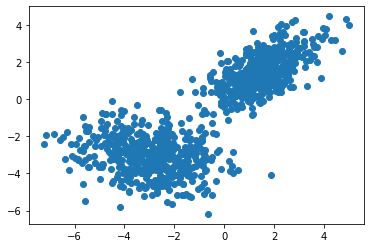

tensor([[-3.2541, -3.3302,  1.0000,  0.0000,  0.0000],
        [ 1.1233,  1.5575,  1.0000,  0.0000,  0.0000],
        [-4.1993, -2.6777,  1.0000,  0.0000,  0.0000],
        ...,
        [-2.0208, -2.6019,  1.0000,  0.0000,  0.0000],
        [ 1.8301,  0.3689,  1.0000,  0.0000,  0.0000],
        [-4.6181, -2.0797,  0.0000,  0.0000,  1.0000]])
tensor([-0.7006, -0.7417,  0.6920,  0.2030,  0.1050])


In [11]:
class ToyMixedDataset(Dataset):
    def __init__(self, num_samples=1000, pvals=[.7, .2, .1],
                 y1_mixture_weight=0.5, mu0=None, mu1=None, sigma0=None, sigma1=None):
        
        if mu0 is None:
            mu0 = np.array([1.5,1.5])

        if mu1 is None:
            mu1 = np.array([-3,-3])

        if sigma0 is None:
            sigma0 = np.array([
                [1, .6],
                [.6, 1]
            ])

        if sigma1 is None:
            sigma1 = np.array([
                [2, -.3],
                [-.3, 1]
            ])

        y = np.random.binomial(1, y1_mixture_weight, size=(num_samples, 1))

        samples_real = np.zeros((num_samples, 2))

        samples_y0 = np.random.multivariate_normal(mu0, sigma0, size=num_samples)
        samples_y1 = np.random.multivariate_normal(mu1, sigma1, size=num_samples)

        samples_real[y.flatten() == 0, :] = samples_y0[y.flatten() == 0, :]
        samples_real[y.flatten() == 1, :] = samples_y1[y.flatten() == 1, :]
        
        samples_cat = np.random.multinomial(1, pvals=pvals, size=num_samples)
        
        samples = np.concatenate((samples_real, samples_cat), axis=1)

        self.data = torch.from_numpy(samples.astype('float32'))
        self.targets = torch.from_numpy(y.flatten().astype('int32'))
            

    def __getitem__(self, index):
  
        return self.data[index], self.targets[index]
        
        
    def __len__(self):
        return len(self.data)
    
    
dataset = ToyMixedDataset(num_samples=1000)
    


fig, ax = plt.subplots()

ax.scatter(dataset.data.numpy()[:, 0].flatten(),
        dataset.data.numpy()[:, 1].flatten()
       )

plt.show()
plt.close()

print(dataset.data)
print(dataset.data.mean(axis=0))

Epoch 500: 100%|██████████| 500/500 [00:34<00:00, 14.38it/s, avg_loss=4.61, kl_penalty=1.21, recon_error=3.4, val_avg_loss=4.68, val_kl_penalty=1.2, val_recon_error=3.47]  


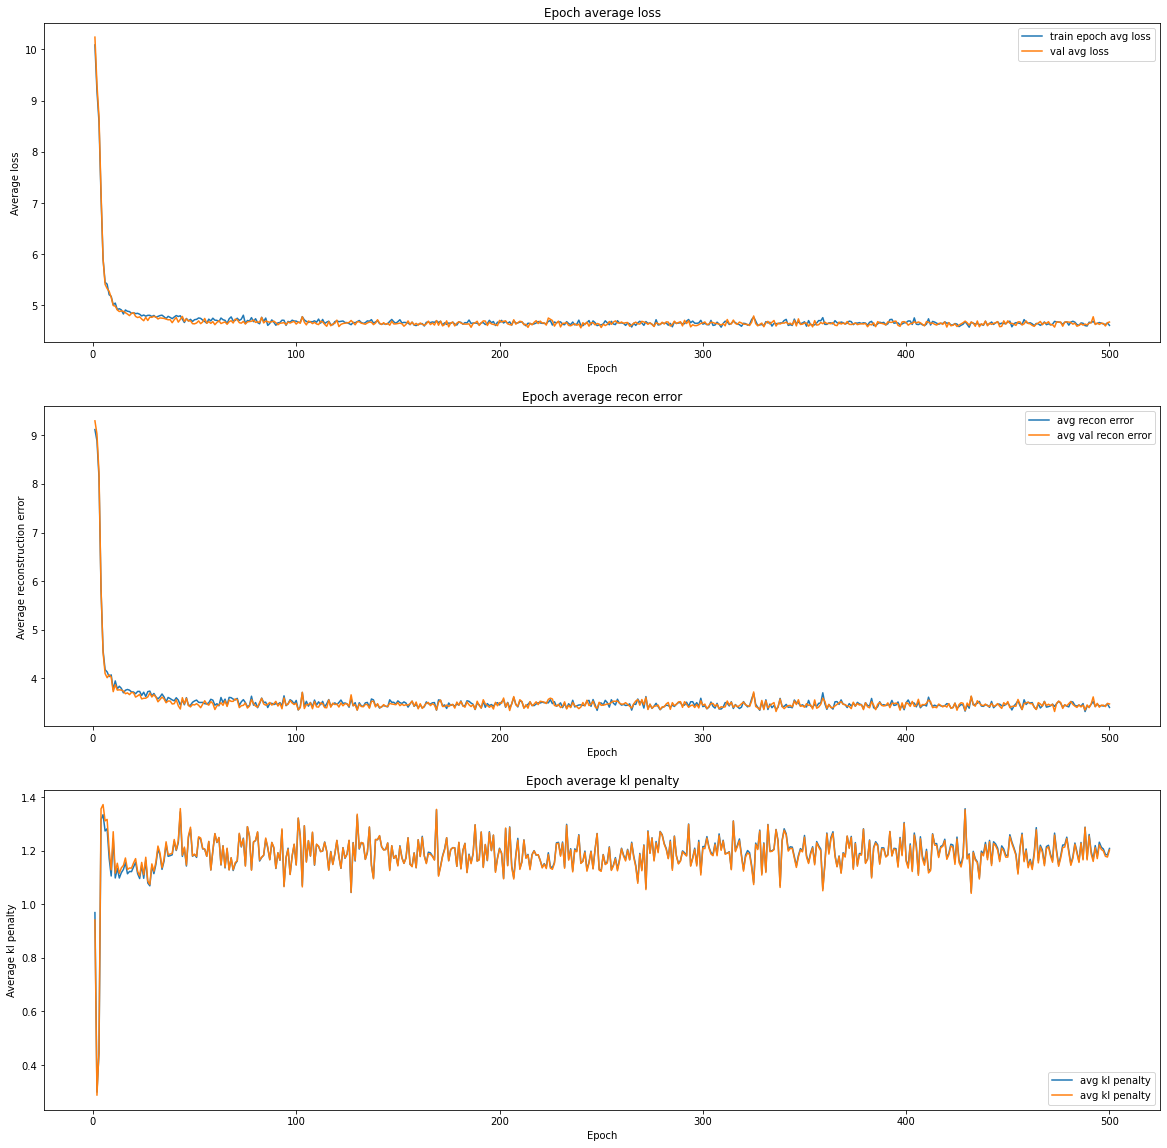

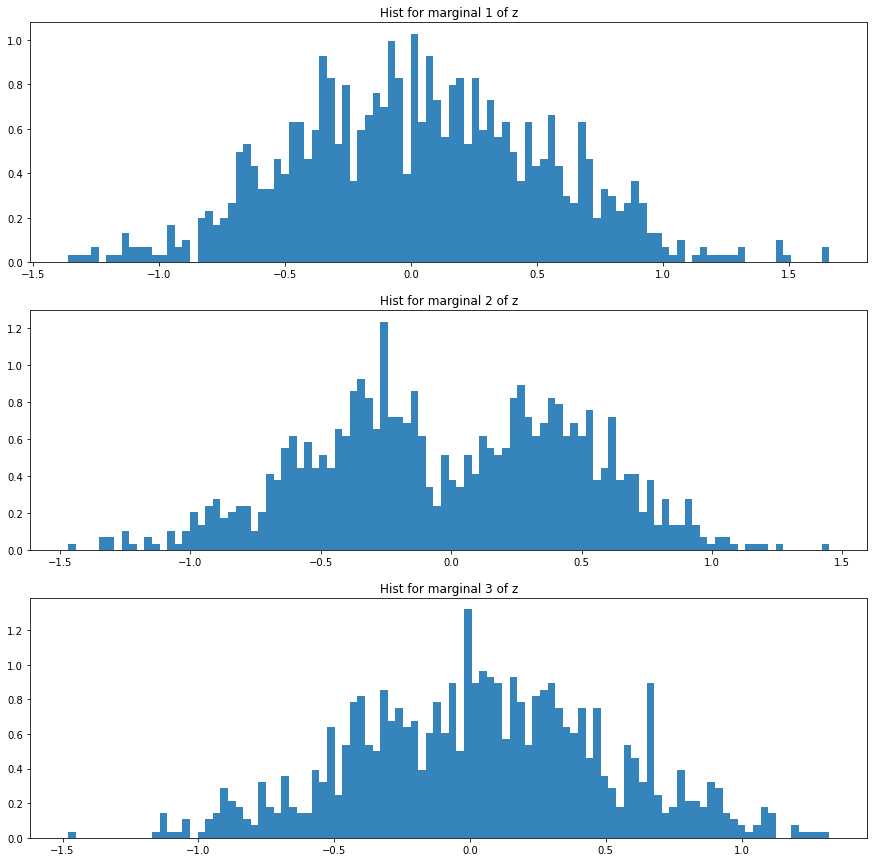

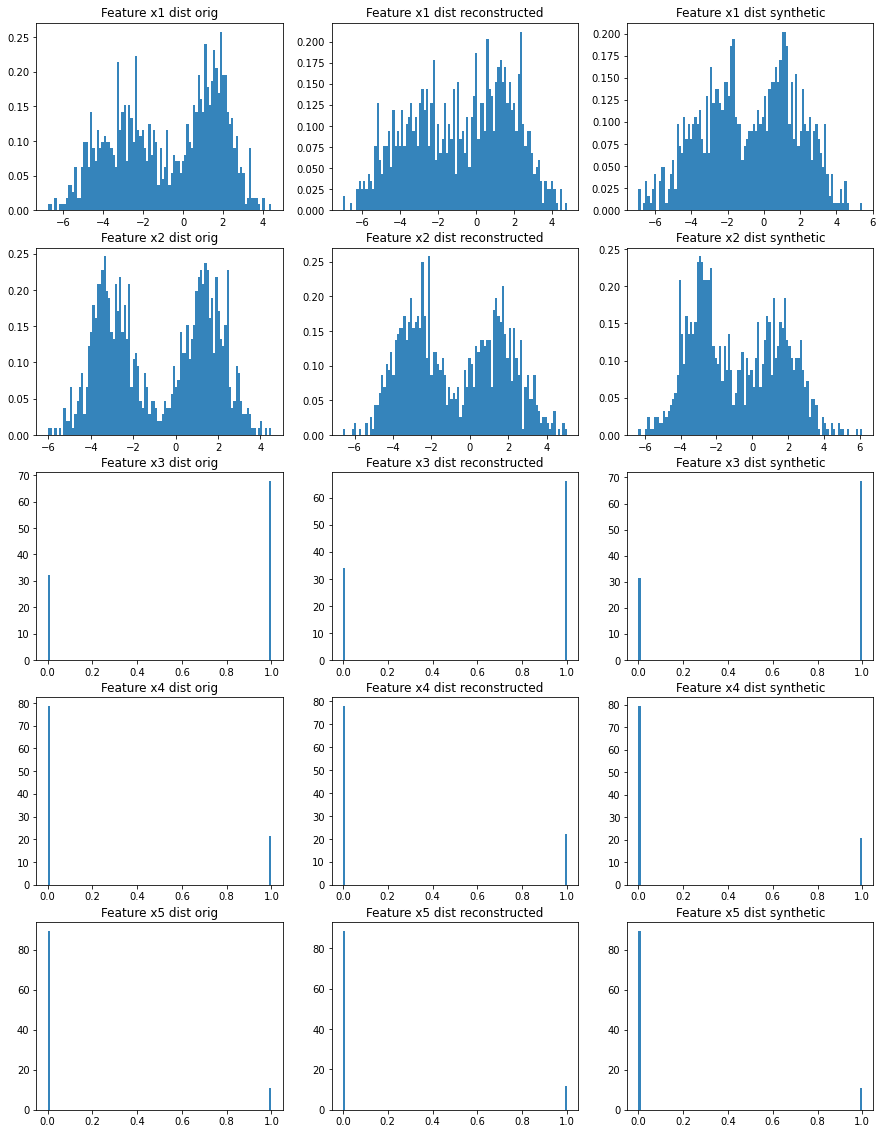

original correlations
          0         1         2         3         4
0  1.000000  0.810799 -0.063033  0.000574  0.094206
1  0.810799  1.000000 -0.028996 -0.023558  0.074866
2 -0.063033 -0.028996  1.000000 -0.757665 -0.503759
3  0.000574 -0.023558 -0.757665  1.000000 -0.182102
4  0.094206  0.074866 -0.503759 -0.182102  1.000000
reconstructed correlations
          0         1         2         3         4
0  1.000000  0.752312 -0.077500  0.029289  0.076492
1  0.752312  1.000000 -0.047142  0.009403  0.057465
2 -0.077500 -0.047142  1.000000 -0.748071 -0.505829
3  0.029289  0.009403 -0.748071  1.000000 -0.194064
4  0.076492  0.057465 -0.505829 -0.194064  1.000000
synthetic correlations
          0         1         2         3         4
0  1.000000  0.757285 -0.083127  0.022672  0.095148
1  0.757285  1.000000 -0.071564 -0.019760  0.133488
2 -0.083127 -0.071564  1.000000 -0.755717 -0.510453
3  0.022672 -0.019760 -0.755717  1.000000 -0.177392
4  0.095148  0.133488 -0.510453 -0.177392  1

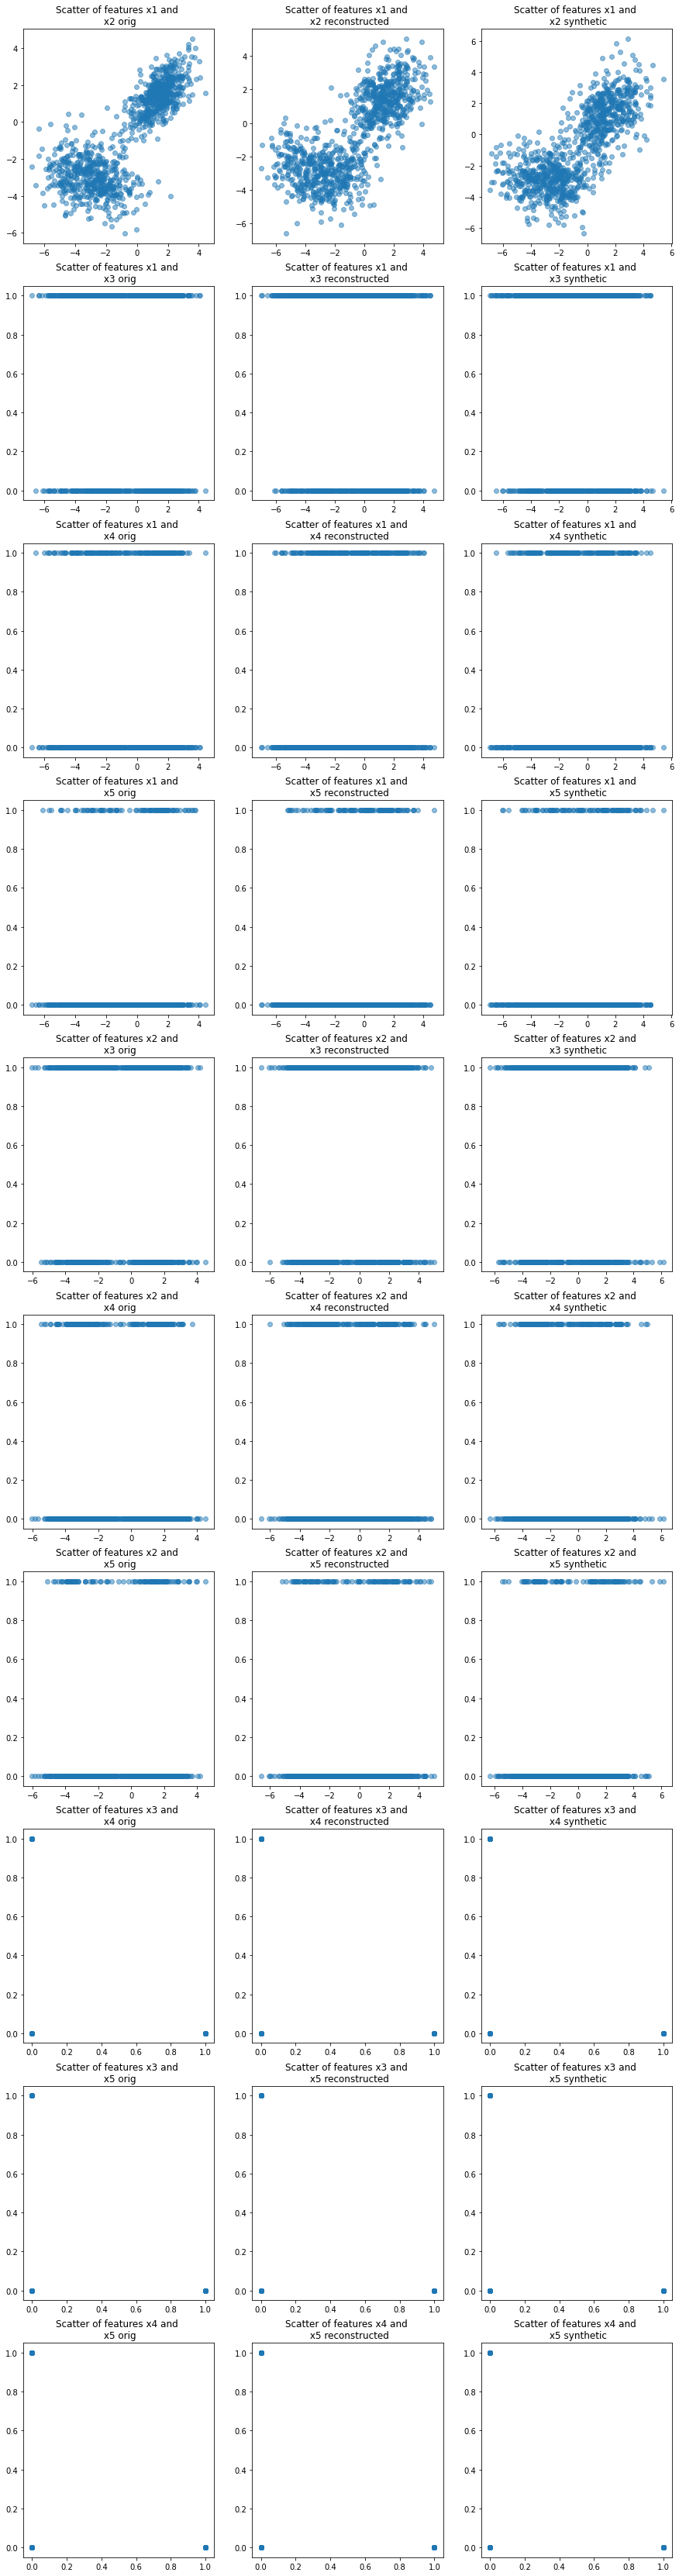

In [12]:
 likelihood_partition = {
                (0, 1): 'real',
                (2, 4): 'categorical'
            }
    
    
vae = HVAE(x_dim=5, 
  z_dim=3, 
  z_prior_var=Z_PRIOR_VAR,
  likelihood_partition=likelihood_partition,
  verbosity=1,
  device='cpu')

train_dataset = ToyMixedDataset(num_samples=1000)
val_dataset = ToyMixedDataset(num_samples=1000)


vae.set_train_dataset(train_dataset, featnames=['x1', 'x2', 'x3', 'x4', 'x5'])
vae.set_val_dataset(val_dataset)
vae.train(num_epochs=NUM_EPOCHS)

plot_history_vae(vae)
debug_nd_vae(vae)    

The categorical proportions from the VAE samples approximately match the ground truth.

In [16]:
samples, _ = vae.sample(S=1000)

print(samples.mean(axis=0))

tensor([-0.6732, -0.7040,  0.6900,  0.2050,  0.1050])


## Complicated Mixed Real-Categorical Example <a class="anchor" id="example2"></a>

The setting is the same as in the previous example, but now the categorical distribution depends on the Gaussian mixture component. The second categorical has proportions [.3, .4, .3].

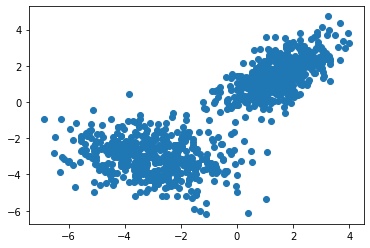

tensor([[-2.9315, -1.9355,  1.0000,  0.0000,  0.0000],
        [ 0.6734,  0.3820,  1.0000,  0.0000,  0.0000],
        [-2.5491, -4.7728,  0.0000,  1.0000,  0.0000],
        ...,
        [-2.3464, -1.8262,  1.0000,  0.0000,  0.0000],
        [-2.5343, -3.7082,  1.0000,  0.0000,  0.0000],
        [-6.0232, -3.3271,  0.0000,  0.0000,  1.0000]])
tensor([1.4606, 1.4445, 0.7429, 0.2004, 0.0567])
tensor([-3.0275, -3.0313,  0.3261,  0.3676,  0.3063])


In [18]:
class ToyMixedDataset(Dataset):
    def __init__(self, num_samples=1000, pvals_y0=[.7, .2, .1],
                 pvals_y1=[.3, .4, .3],
                 y1_mixture_weight=0.5, mu0=None, mu1=None, sigma0=None, sigma1=None):
        
        if mu0 is None:
            mu0 = np.array([1.5,1.5])

        if mu1 is None:
            mu1 = np.array([-3,-3])

        if sigma0 is None:
            sigma0 = np.array([
                [1, .6],
                [.6, 1]
            ])

        if sigma1 is None:
            sigma1 = np.array([
                [2, -.3],
                [-.3, 1]
            ])

        y = np.random.binomial(1, y1_mixture_weight, size=(num_samples, 1))
        self.y = y

        samples_real = np.zeros((num_samples, 2))
        samples_cat = np.zeros((num_samples, 3))

        samples_y0 = np.random.multivariate_normal(mu0, sigma0, size=num_samples)
        samples_y1 = np.random.multivariate_normal(mu1, sigma1, size=num_samples)

        samples_real[y.flatten() == 0, :] = samples_y0[y.flatten() == 0, :]
        samples_real[y.flatten() == 1, :] = samples_y1[y.flatten() == 1, :]
        
        samples_cat_y0 = np.random.multinomial(1, pvals=pvals_y0, size=num_samples)
        samples_cat_y1 = np.random.multinomial(1, pvals=pvals_y1, size=num_samples)
        
        samples_cat[y.flatten() == 0, :] = samples_cat_y0[y.flatten() == 0, :]
        samples_cat[y.flatten() == 1, :] = samples_cat_y1[y.flatten() == 1, :]
        
        samples = np.concatenate((samples_real, samples_cat), axis=1)

        self.data = torch.from_numpy(samples.astype('float32'))
        self.targets = torch.from_numpy(y.flatten().astype('int32'))
            

    def __getitem__(self, index):
  
        return self.data[index], self.targets[index]
        
        
    def __len__(self):
        return len(self.data)
    
    
dataset = ToyMixedDataset(num_samples=1000)
    


fig, ax = plt.subplots()

ax.scatter(dataset.data.numpy()[:, 0].flatten(),
        dataset.data.numpy()[:, 1].flatten()
       )

plt.show()
plt.close()

print(dataset.data)
print(dataset.data[dataset.targets.flatten() == 0].mean(axis=0))
print(dataset.data[dataset.targets.flatten() == 1].mean(axis=0))

Epoch 500: 100%|██████████| 500/500 [00:34<00:00, 14.63it/s, avg_loss=4.73, kl_penalty=1.23, recon_error=3.51, val_avg_loss=4.68, val_kl_penalty=1.21, val_recon_error=3.47]


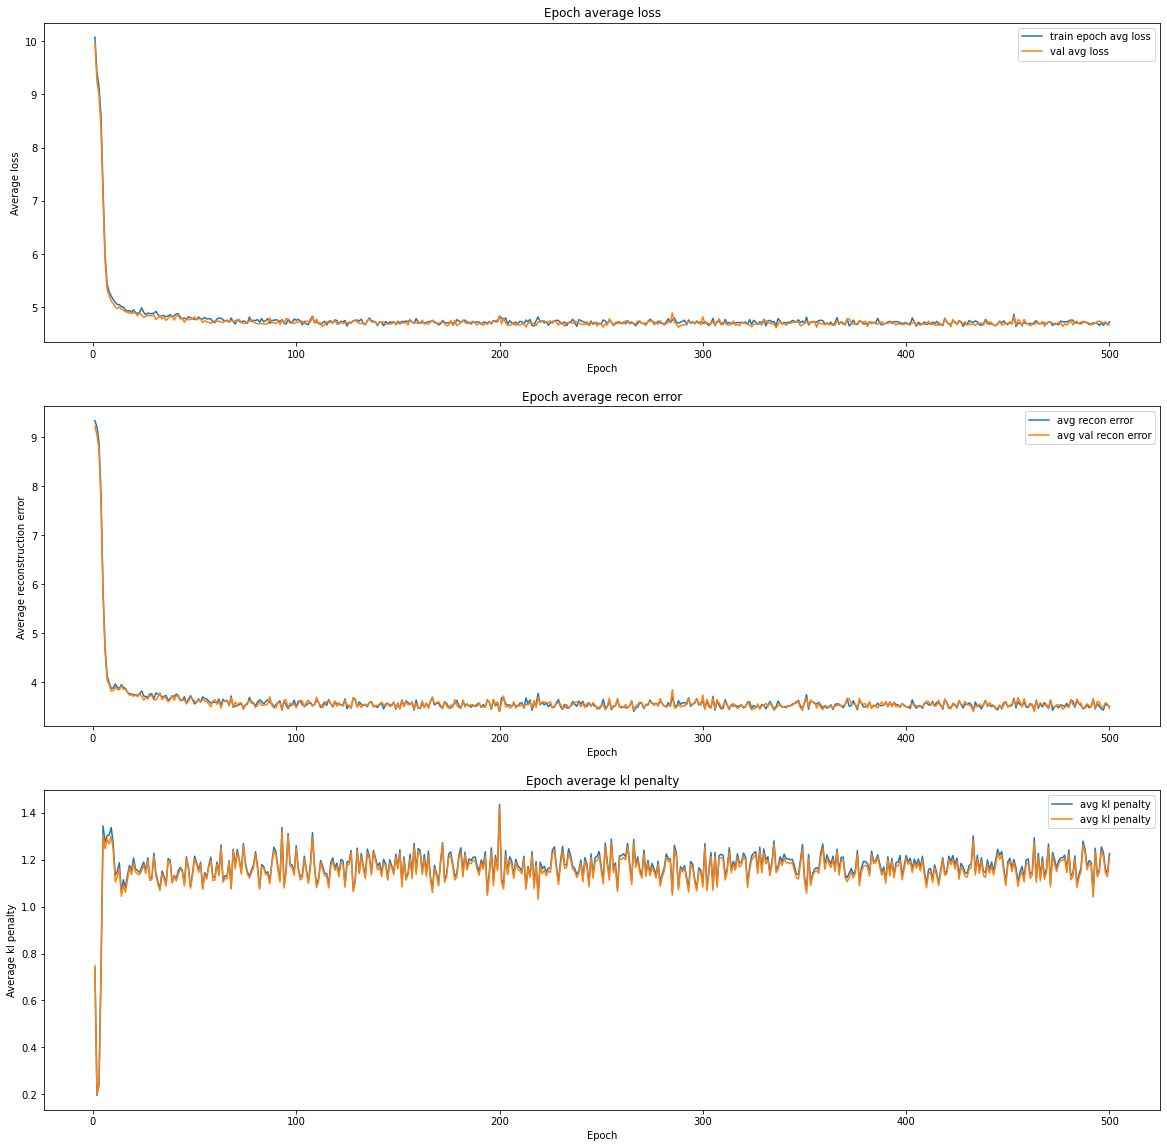

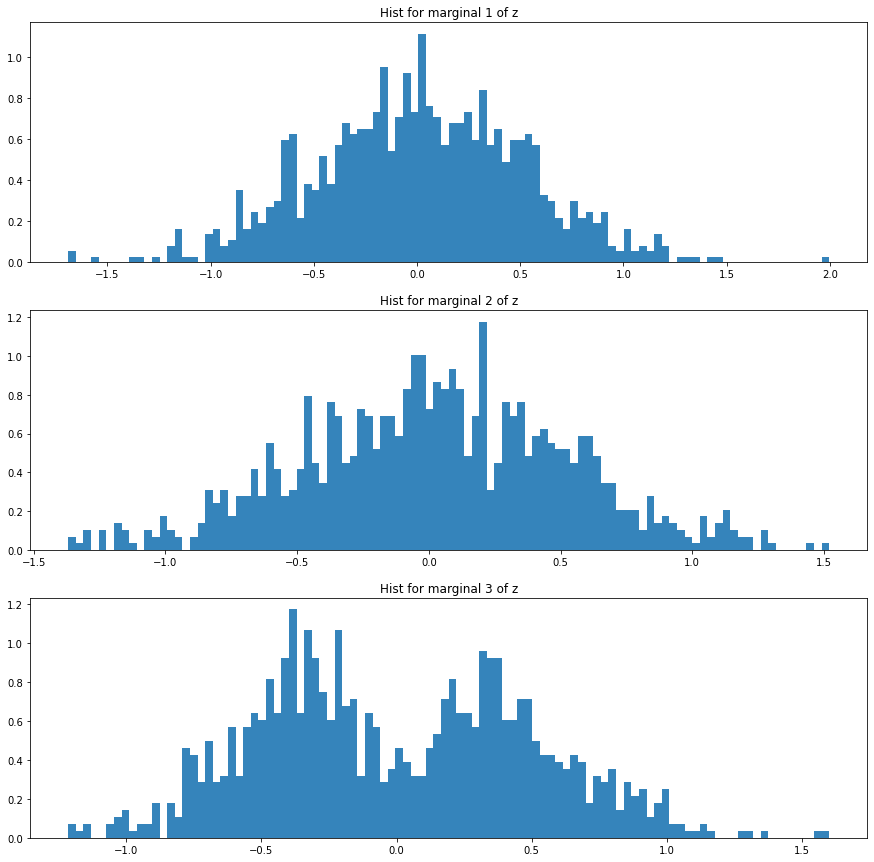

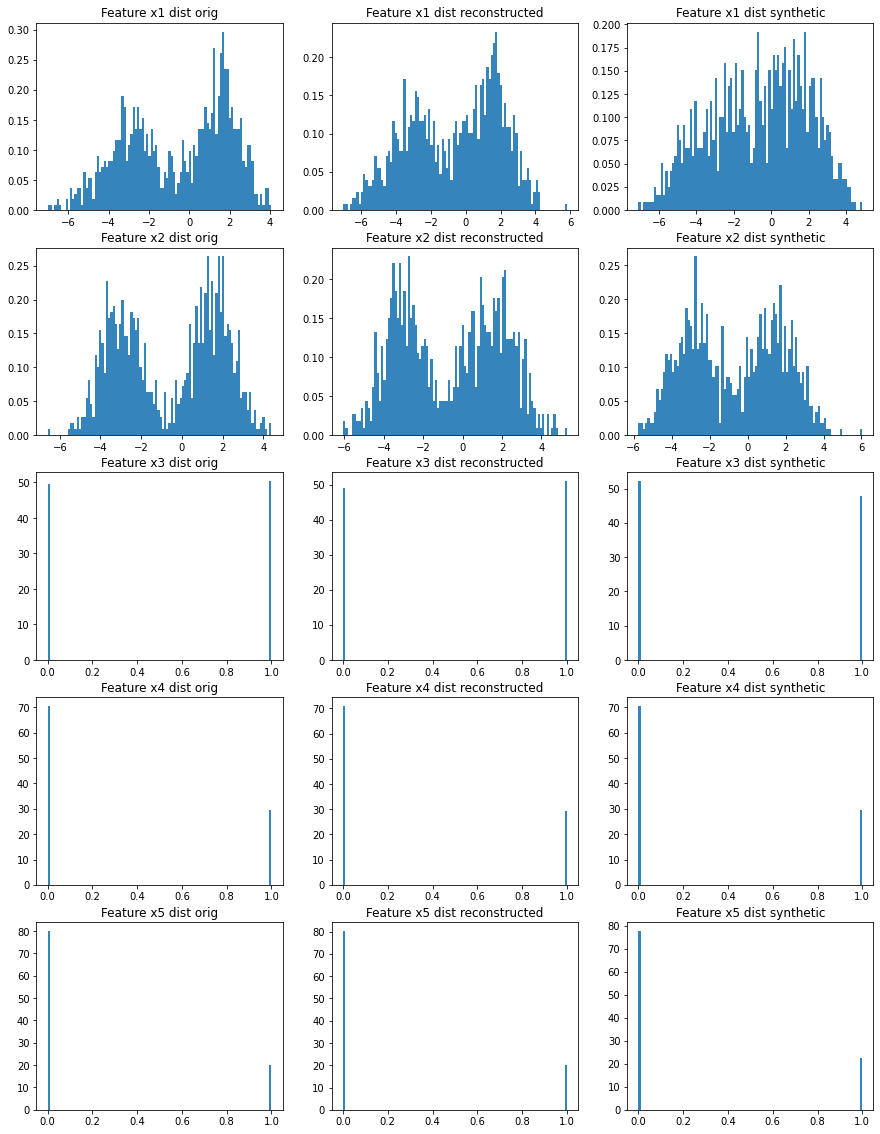

original correlations
          0         1         2         3         4
0  1.000000  0.838933  0.368813 -0.152384 -0.286566
1  0.838933  1.000000  0.381273 -0.154508 -0.299694
2  0.368813  0.381273  1.000000 -0.652327 -0.504580
3 -0.152384 -0.154508 -0.652327  1.000000 -0.325225
4 -0.286566 -0.299694 -0.504580 -0.325225  1.000000
reconstructed correlations
          0         1         2         3         4
0  1.000000  0.775820  0.356584 -0.149169 -0.276616
1  0.775820  1.000000  0.360131 -0.138659 -0.293028
2  0.356584  0.360131  1.000000 -0.653872 -0.507491
3 -0.149169 -0.138659 -0.653872  1.000000 -0.320100
4 -0.276616 -0.293028 -0.507491 -0.320100  1.000000
synthetic correlations
          0         1         2         3         4
0  1.000000  0.759363  0.374367 -0.184366 -0.246315
1  0.759363  1.000000  0.352190 -0.172830 -0.232396
2  0.374367  0.352190  1.000000 -0.621739 -0.516642
3 -0.184366 -0.172830 -0.621739  1.000000 -0.349382
4 -0.246315 -0.232396 -0.516642 -0.349382  1

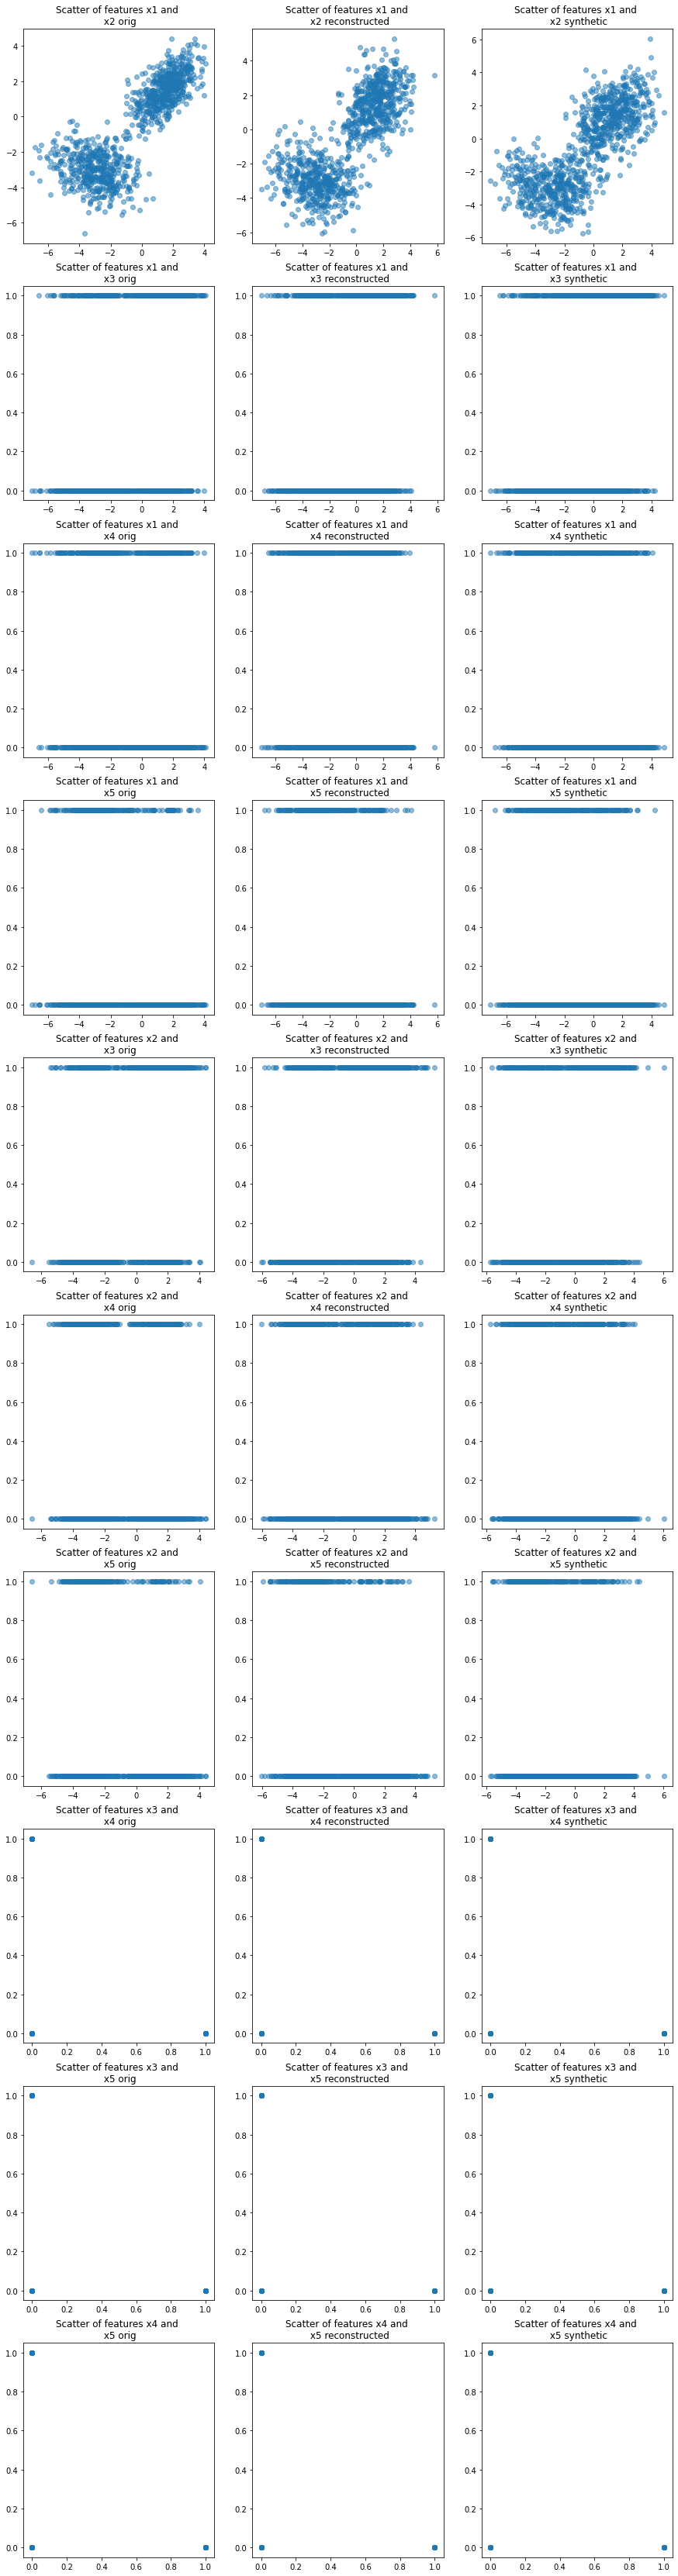

In [19]:
 likelihood_partition = {
                (0, 1): 'real',
                (2, 4): 'categorical'
            }
    
    
vae = HVAE(x_dim=5, 
  z_dim=3, 
  z_prior_var=Z_PRIOR_VAR,
  likelihood_partition=likelihood_partition,
  verbosity=1,
  device='cpu')

train_dataset = ToyMixedDataset(num_samples=1000)
val_dataset = ToyMixedDataset(num_samples=1000)


vae.set_train_dataset(train_dataset, featnames=['x1', 'x2', 'x3', 'x4', 'x5'])
vae.set_val_dataset(val_dataset)
vae.train(num_epochs=NUM_EPOCHS)

plot_history_vae(vae)
debug_nd_vae(vae)    

The VAE successfully captures that there are two categoricals and the proportions depend on the mixture component. 

In [27]:
samples, _ = vae.sample(S=1000)

samples_probably_comp1 = samples[samples[:, 0] > 1.5, :]
samples_probably_comp2 = samples[samples[:, 0] < -3, :]

print(samples.mean(axis=0))
print(samples_probably_comp1.mean(axis=0))
print(samples_probably_comp2.mean(axis=0))

tensor([-0.4735, -0.5375,  0.5200,  0.2960,  0.1840])
tensor([2.5701, 1.7517, 0.7586, 0.1724, 0.0690])
tensor([-4.3060, -2.8733,  0.3116,  0.3920,  0.2965])


In [23]:
samples_probably_comp1

tensor([[-4.6070, -1.9974,  1.0000,  0.0000,  0.0000],
        [-4.5319, -3.3186,  0.0000,  1.0000,  0.0000],
        [-4.2531, -4.2537,  1.0000,  0.0000,  0.0000],
        ...,
        [-3.7695, -5.2348,  0.0000,  1.0000,  0.0000],
        [-3.2405, -2.7481,  0.0000,  0.0000,  1.0000],
        [-3.2514, -5.2903,  1.0000,  0.0000,  0.0000]])